# Classification and Regression: how good is your model?

What is **model validation** and why is it important? Is your model performing **well** and how do you measure that? There are a few questions that you should **always** ask yourself if you are doing machine learning, or fitting any model to your data. Just a few of them here...

    Is your model performing well?
    Is it overfitted or underfitted?
    Does it perform better than the null model?
    Is is generalisable?

If you worked on machine learning in the past, you probably know how to answer all these questions, and this workshop might be easy from the machine learning point of view. But hopefully, you will still learn something new. Instead, if you didn't, this is your opportunity to learn more about it. 

Model validation and assessment of model performance are probably two of the most important aspects in machine learning. If you don't validate your model, then you might end up having a model that performs very well on a specific dataset, but very badly on another dataset, making it useless and not generalisable. Similarly, assessing model performance is fundamental, because, after all, having a high performing model is what all machine learning researchers try to achieve. 

In order to try to make the workshop interesting both for people with experience in Python/ML, and people without, the workshop will be characterised by some theory and some small *coding challenges*. The coding challenges will have two different levels: the *coding challenges* marked as **BONUS** will be slightly more advanced, so if you are not super familiar with ML, and/or Python, feel free to skip them. However, read the text under the **BONUS CODE HERE** section, because they will explain new aspects of model validation and assessment of performance. If you end up being curious on how to actually complete the BONUS CODE sections in the future, feel free to drop me an email.

In [124]:
import random
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing   import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings("ignore")
sb.set_theme("talk")
sb.set_style("whitegrid")

Let's start by importing the dataset and checking what it means. The data was publicly available [here](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset). If you are curious, each column means the following:

| Column | Description | 
| --- | --- | 
| age | age of participants|
|sex | sex of participants|
|cp |chest pain type (4 values)|
|trestbps |resting blood pressure|
|chol|serum cholestoral in mg/dl|
|fbs| fasting blood sugar > 120 mg/dl|
|restecg| resting electrocardiographic results (values 0,1,2)|
|thalach| maximum heart rate achieved|
|exang| exercise induced angina|
|oldpeak| ST depression induced by exercise relative to rest|
|slope| the slope of the peak exercise ST segment|
|ca| number of major vessels (0-3) colored by flourosopy|
|thal| 0 = normal; 1 = fixed defect; 2 = reversable defect|
|target|whether the participants have a heart disease or not|

The target column is what we want to predict using the remaining features. Since our data have a label (or target), and this label is categorical, then we will be completing a **supervised machine learning (ML) classification** task. Aftwerwards, we will try to predict the age of participants based on the other features. In this case, since the label is continous, we will be completing a **supervised ML regression task**. 

In [27]:
heart = pd.read_csv("Workshop1/heart.csv") # Read csv file
heart.head(n = 5)                          # Print the first five rows of the dataframe

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Classification

The first step of any ML pipeline for a classification task is to split the data in X (or predictors), and Y, and check how many participants there are in each class. This allows us to assess whether there is **class imbalance**. **Class imbalance** is a problem because it can influence the training of the model, and if the imbalance is high, then the model will tend to predict every sample as having the label of the majority class (or class with higher number of samples). However, class imbalance is also important because it affects the way you can assess **performance**. Let's think about this example: if you have 100 participants, and 90 of these participants are healthy (class 0) and 10 have a heart disease (class 1), then if the model predicts all participants as being healthy, it will still get 90 right out of 100, so it will be correct 90% of the times. This measure of performance is called **accuracy**, and is calculated as follows:

$$Accuracy = \frac{NumberCorrectPredictions}{TotalPredictions} $$

Accuracy is one of the most commonly used measures of performance. However, having an accuracy of 90% in this case is not good, because the model cannot distinguish between healthy controls and patients with heart disease. If you were to assess the performance of your model using accuracy as a measure, then your results would be highly misleading...

To solve these issues related to class imbalance there are two things that can be done:
1. Reduce class imbalance before the training of the model (oversampling or undersampling) or address the imbalance during the training of the model (loss penalisation or ensemble learning)
2. Adapt the model performance assessment in order to use metrics that are robust against class imbalance



In [115]:
Y = heart["target"]                 # Extract the column target from heart dataframe
X = heart.drop("target", axis = 1)  # Drop the column target from the heart dataframe

Y.value_counts(normalize = True)    # Obtain a percentage of the values in Y

1    0.544554
0    0.455446
Name: target, dtype: float64

As you can see, our data have class imbalance, but the imbalance is limited. It can happen to have an imbalance of up to 80/20. Since the imbalance is small, and class imbalance is beyond the scope of this workshop, we will address the issue by adapting the way we calculate the model performance, and by adding a weight to the loss. 

After checking for class imbalance, the next step is to randomly split the data into **train** and **test**. The **train** and **test** split is a fundamental step of **model validation**. Indeed, it can happen that a model performs very well on the data on which it was trained, but very poorly on others, meaning that the model is not **generalisable**. This is called **overfitting**, and it occurs when the model learns *too well* the data on which it was trained. Of course, the opposite can occur as well, namely the model performing poorly both on the data on which it was trained and on new data. This is called **underfitting** and it occurs when the model cannot properly learn from the data how to make the correct predictions. 

Overfitting and underfitting can occur both in case of regression and classification tasks, as shown in the follwoings figures (taken from [here](https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/) and [here](https://jashrathod.github.io/2021-09-30-underfitting-overfitting-and-regularization/)).

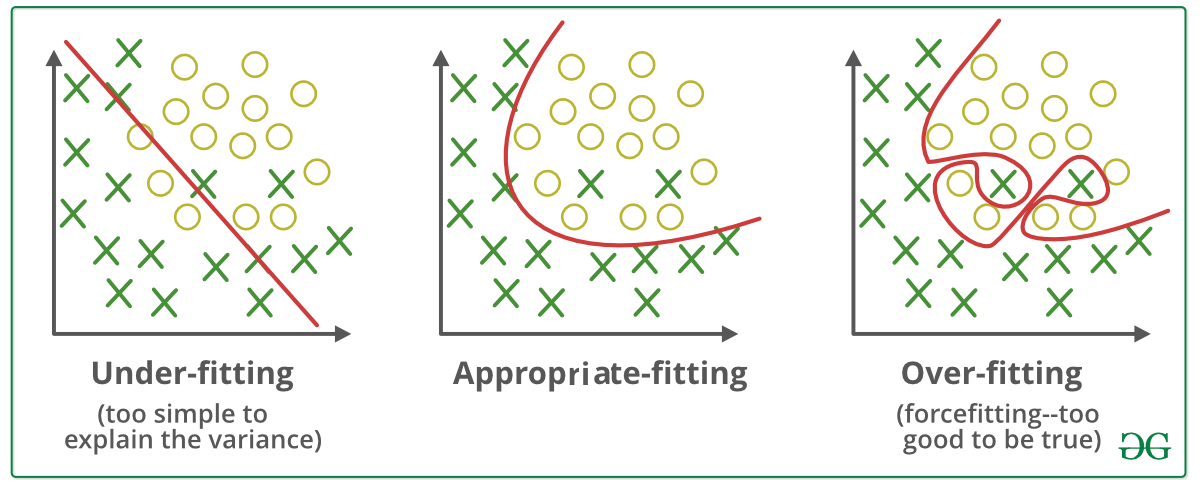


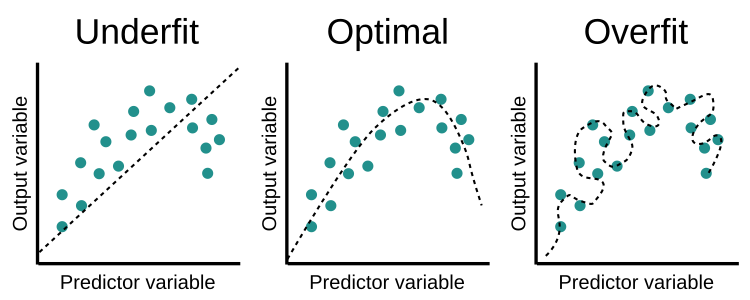

Common causes of overfitting are: 
1. A too high complexity of the model relative to the data on which it was trained, 
2. a too high numbers of features used for the training of the model. 

Instead, common causes of underfitting are: 
1. too low number of samples, 
2. not enough features to properly learn how to make the predictions.

Train and test split is a good way to assess whether the models are overfitted or underfitted. By splitting the data, it is possible to check whether the model performs well when making predictions both on the data on which it was trained (i.e. the train set), and on a separate dataset (i.e. the test set).
* If the performance on the train set is high, but on the test set is low, then the model is likely to be overfitted. 
* If the performance on the train and test set is low, then the model is likely to be underfitted. 
* If the performance on the train and test set is high, then the model is neither overfitted nor underfitted.


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=12, 
                                                    shuffle=True, stratify=Y)

Let's train a classification model using Support Vector Machines (SVC), which is a type of classification algorithm.

In [117]:
# Scale the datasets (scaling is important in ML as it tends to lead to better performance)
# Intialise standard scaler
scaler = StandardScaler()
# Fit the scaler to the train data and transform the train data
X_train = scaler.fit_transform(X_train)
# Fit the scaler to the train data and transform the train data

X_test = scaler.transform(X_test)

# Initialise the classifier

classifier = SVC(class_weight = "balanced", random_state=10, kernel = "rbf")

# Train a Support Vector Machines classifier on the train set 

classifier.fit(X_train, y_train)

# Get predictions for the training and testing sets

y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

# Calculate the train and test accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Print the train and test accuracy
print("Training set accuracy: ", accuracy_train)
print("Testing set accuracy: ", accuracy_test)

Training set accuracy:  0.5311355311355311
Testing set accuracy:  0.03333333333333333


By looking at the results, the model appears to perform better on the training set compared to the test set, which could be a sign of overfitting. However, the model performs well on the test set as well, which suggests that it seems to be able to generalise to different dataset. 

Of course, since we metioned at the beginning that the data have a class imbalance, accuracy might not be the best way to assess the performance of the model.

--------------
### Code here

1. **CODE HERE:**
    * Assess what is the number of True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN), by comparing the predicted labels to the actual labels. These measures are more reliable when there is a class imbalance
    * Obtain a **confusion matrix**, which corresponds to a contingency table with two dimensions ("actual" and "predicted"), each one with all the possible number of classes (i.e. 2 in this case). The confusion matrix corrsponds to a simple way to visualise the numbers of TP, TN, FP and FN. An example of confusion matrix is available in the following figure.
    
    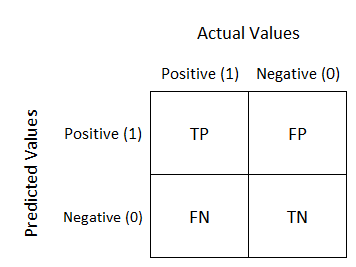
    
    * Plot the confusion matrix as a heatmap
    
    
2. **BONUS CODE HERE:** 
    * Define a function that calculates from scratch the F1 score, and use it to assess model performance. The **F1 score** is probably one of the most commonly used metrics to assess performance in classification tasks. It is useful, because it is quite straightforward to calculate and it is highly robust to class imbalance. It is commonly defined as the *harmonic mean of precision and recall*. To calculate it, you need to implement the following three equations:
    $$Precision = \frac {TP} {TP+FP} $$
    
    $$ Recall = \frac {TP} {TP+FN} $$
    
    $$F1 = \frac {2*(Precision*Recall)}{Precision + Recall}$$
    * Plot the **ROC (Area Under the Receiver Operating Characteristics)** from scratch. The ROC curve is a visualisation method used to show the performance of a classification model at different classification thresholds. When a model makes a prediction, it assigns a probability for each class (class 0 vs class 1) for each participant. Then, a threhsold can be applied to classify each participant as belonging to a class or the other. To create a ROC curve, you have to check different thresholds, get the confusion matrix for each threshold, and get the false and true positive rate for each of them.
 


In [39]:
# CODE HERE

--------

## K-Fold cross validation

Although the train/test split is important for model validation, there are some issues related to it. First of all, since the train/test split occurs only one time, it can happen that by chance all the samples that end up in the test set are easier to predict compared to the others. This can be problematic, because if the samples are easier to predict, then the model will perform well on the test set, but that doesn't necessarily mean that your model is generalisable. Indeed, in that case, if you decided to run the train/test split again, then the model would perform worse. 

Let's think about this example: you want to predict whether participants have Alzheimer's using their performance in different cognitive tasks. One of these cognitive tasks assesses the memory of different participants, and can have a value between 0 and 1, where 0 corresponds to terrible memory. When participants have a score of 0 in this test, then they clearly have Alzheimer's. But what about the participants that have a score of 0.5? These participants are clearly harder to predict... and the model cannot assess whether they have Alzheimer's only based on their performance in that task.

As you can see, the train/test split can play a role in your model validation and performance. To address this issue, it is common in ML to complete K-Fold cross validation. K-fold cross validation consits of splitting your dataset into K folds, and by training K models, where each model is trained using K-1 folds, and tested on the remaining 1 fold. The fold used for the test set is different for each model. In this way, all samples in the dataset end up being used as test set, and the issue of the random splitting is fully addressed, making the model validation more robust.

The performance of each model is calculcated and the final model performance corresponds to the average across the performances of the K models trained on different folds (as described in the following figure taken from [here](https://zitaoshen.rbind.io/project/machine_learning/machine-learning-101-cross-vaildation/))

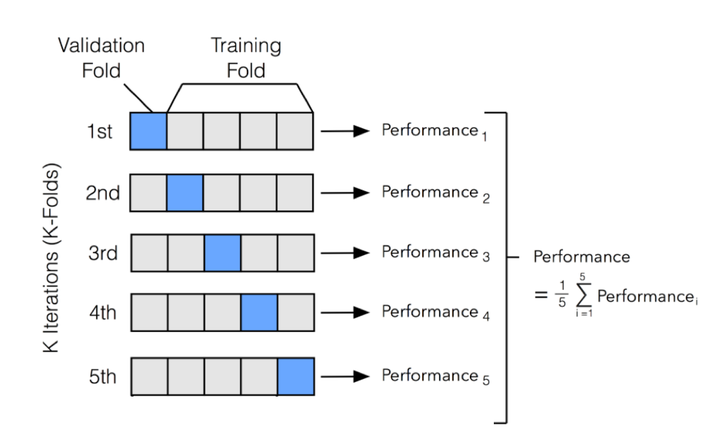

K-Fold cross validation is really useful also in another circumstance, which is for the fine-tuning of **hyperparameters.** Hyperparameters are parameters that are **external** to the model, that need to be defined by the user and that influence the training of the model. A common way to fine-tune hyperparameters is to train multiple models using different possible combinations, and evaluate which model performs the best. In this case, K-Fold cross validation can be used, but it is applied only on the training set (as described in the figure, taken from [here](https://scikit-learn.org/stable/modules/cross_validation.html)). If you have done ML in the past, you are probably familiar with this concept. If you aren't, don't worry about it!

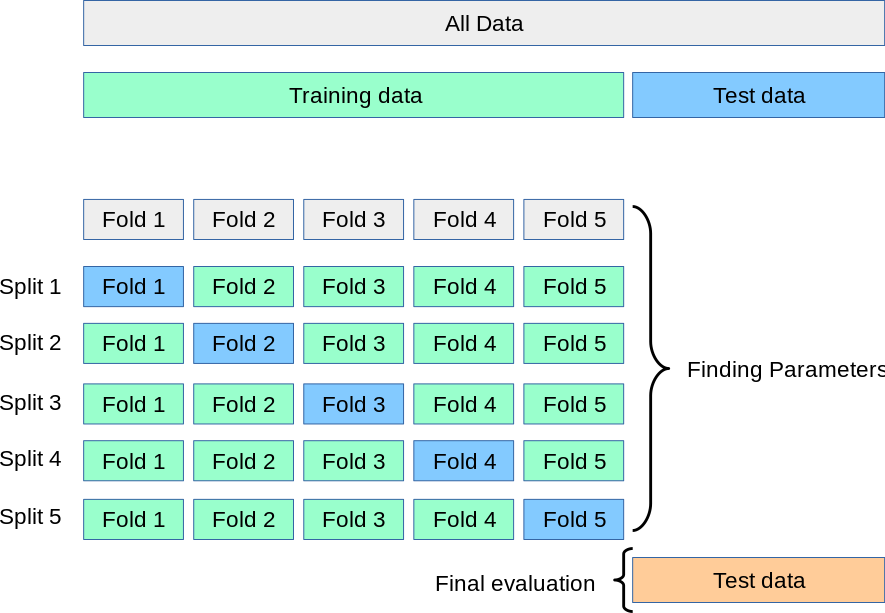

Let's now implemet it in Python.

In [118]:
# Set a number of folds
number_folds = 10

# Initiate k-fold splits
kfolds = KFold(n_splits=number_folds, shuffle=True, random_state=10)

# Initialise an empty list where the accuracies obtained on each fold will be stored
accuracies = []

# Loop through the folds
for train_index, test_index in kfolds.split(X, Y):
    
    # Obtain the different folds, or data subsets for X 
    X_train, X_test = X.loc[train_index], X.loc[test_index] 
    
    # Obtain the different folds, or data subsets for y
    y_train, y_test = Y.loc[train_index], Y.loc[test_index]
    
    # Scale the datasets (scaling is important in ML as it tends to lead to better performance)
    # Intialise standard scaler
    scaler = StandardScaler()
    # Fit the scaler to the train data and transform the train data
    X_train = scaler.fit_transform(X_train)
    # Transform the test data using the scaler trained on the train data
    X_test = scaler.transform(X_test)

    # Train the classifier (Support vector machines)
    # Intialise the classifier
    classifier = SVC(class_weight='balanced', random_state=12)
    # Train the model on the train dataset
    classifier.fit(X_train, y_train)
    # Use the model to predict the test datase
    y_pred_test = classifier.predict(X_test)
    
    # Get accurancy on current test fold and append them to the list
    accuracies.append(accuracy_score(y_test, y_pred_test))
    
accuracies

[0.8387096774193549,
 0.7419354838709677,
 0.8387096774193549,
 0.8333333333333334,
 0.8333333333333334,
 0.8,
 0.7666666666666667,
 0.9,
 0.8666666666666667,
 0.8666666666666667]

As you can see, the accuracy changes depending on the data used in the test set, which suggests that the samples in the dataset are not equally easy to predict. Let's plot the accuracies using a boxplot.

<AxesSubplot:>

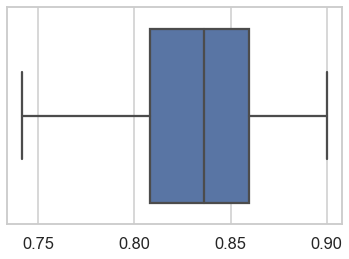

In [125]:
sb.boxplot(accuracies)

--------------
### Code here

1. **CODE HERE:**
    * Calculate the mean accuracy across the K folds
    * Implement **leave-one out cross validation**. Leave one out cross validation is commonly used when the size of the dataset is small. It corresponds to a particular case of K-Fold cross validation where the number of folds is equivalent to the number of samples, resulting in a test set consisting of only one sample. After implementing leave one out cross validation, calculate the mean accuracy across the folds. 
    
    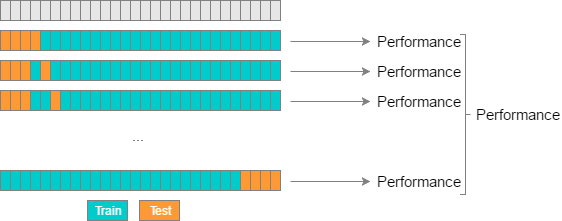
    
2. **BONUS CODE HERE:** 
    * Use k-fold cross validation on the training set to fine-tune 1 (or 2) hyperparameters of choice (e.g. C, gamma or kernel). Use grid search as method for hyperparameters fine-tuning. Grid-search consists of checking all possible combinations of hyperparameters by assessing the performance of the model with each one of these combinations. Use 5-fold cross validation within the training set. Select the best combination of hyperparameters, and then use it to train the final model using the full training set and testing it on the test set. 
    

In [17]:
# CODE HERE

--------

## Model significance

Up to now, we have learnt how to implement different model validations and performance metrics. Now, however, we will make a step further, and assess the significance of the model. What does **significance of the model** mean? Let's say that we have a model with an accuracy of 60% (assuming there is no class imbalance). Is this accuracy good or bad? Well, of course, the higher is the accuracy and the better it is. But obtaining models with ~90% accuracy is not that common. At the same time, however, if your model performs the same as a random model, namely a model where the labels (or targets) where randomly permuted, then the model for sure is not good. 

Models with a 60% accuracy can be both better or worse than a **null model**, or model with permuted/shuffled labels. The model significance is a measure to assess whether your model is better than the null model. To obtain a measure of significance,  it is possible to use **permutation analysis**. The best way to learn permutation analysis is by checking out [this tutorial](https://www.jwilber.me/permutationtest/). 

In brief, permutation analysis is a method that consists of training N  models, where the label of the train set is shuffled/permuted, resulting in N null models. The performance of these null models on the test set returns the null distribution. The more null models perform better than the actual model, the less significant is the actual model.

Let's see how to implement it in Python

In [119]:
N = 500
accuracies_permuted = []

for permutation in tqdm(range(N)):
    # Randomly shuffle the y labels
    random.shuffle(y_train.values)
    
    # Train a SVC classfier
    classifier = SVC(class_weight='balanced', random_state=12)
    classifier.fit(X_train, y_train)
    
    # Predict using the model
    y_pred_test = classifier.predict(X_test)

    # Get accurancy on current test set and append to the list
    accuracies_permuted.append(accuracy_score(y_test, y_pred_test))
print(accuracies_permuted[1:10])

100%|██████████| 500/500 [00:02<00:00, 199.57it/s]

[0.7, 0.6, 0.5333333333333333, 0.3333333333333333, 0.23333333333333334, 0.5333333333333333, 0.6666666666666666, 0.3, 0.4666666666666667]


--------------
### Code here

1. **CODE HERE:** 

    * Create a histogram plot of the distributions of the null accuracies (**null disrtibution**), and add a red vertical line where the mean accuracy of the true model is. Are there many null models that perform better than your actual model?
    
    
2. **BONUS CODE HERE:** 

    * Calculate the p-value of the model. Is the actual model significantly better than the null model?
    * Repeat the permutation analysis using the F1-Score instead of the accuracy. Do the results change?
    


In [38]:
## CODE HERE


-------

# Regression analysis

Regression analysis is a type of supervised ML model used to predict continuous labels (e.g. age). In this part of the workshop, we will try to use different features to predict the age of participants, and learn about two common metrics used to assess the performance of regression models (e.g. the **R2** and the **mean squared error**).

We will start by training a simple regression model, which tries to predict age from the remaining features in the dataset. As in the case of classification, we have to split the dataset into train and test. Also in this case, we could use K-Fold cross validation to obtain the final measure of performance of the model. However, in case of regression, metrics such as the F1 score or accuracy cannot be used. 

In [120]:
# Extract the column age from heart dataframe
Y = heart["age"]    

# Drop the column age and target from heart dataframe
X = heart.drop(["age", "target"], axis = 1)

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=10, 
                                                    shuffle=True)
# Intialise standard scaler
scaler = StandardScaler()

# Fit the scaler to the train data and transform the train data
X_train = scaler.fit_transform(X_train)

# Transform the test data using the scaler trained on the train data
X_test = scaler.transform(X_test)

# Intialise regression algorithm
lin_reg = LinearRegression()

# Train regression model
lin_reg.fit(X_train,y_train)

# Predict the age using the test set
y_pred = lin_reg.predict(X_test)

An easy way to check whether the predicted values are close to the actual values is to plot a scatterplot.

Text(0, 0.5, 'Prediction')

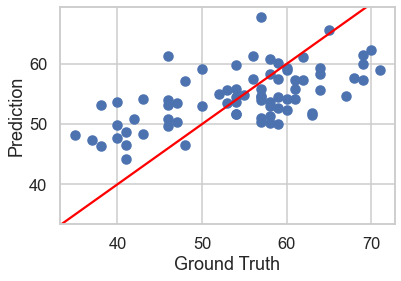

In [126]:
plt.scatter(y_test, y_pred)
plt.axline(xy1 = (35,35), slope=1, c = "red")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")

If the prediction was 100% correct, then all the dots would be located on the red line. Note that here we are not plotting X vs Y (or predictor variable vs outcome variable, like in the figure above), so the red line does not represent the predictions of the model.

Instead the red line is simply a diagonal line, that is in this case where the ground truth would meet the prediction. Hence, if we were predicting age correctly, all predictions would match the ground truth (i.e. all dots would fall on the diagonal red line).

But this is not the case... which suggests that the model is not perfect. How can we quantify how good is the model? 
Let's see how far are the dots from the red line.

Text(0, 0.5, 'Prediction')

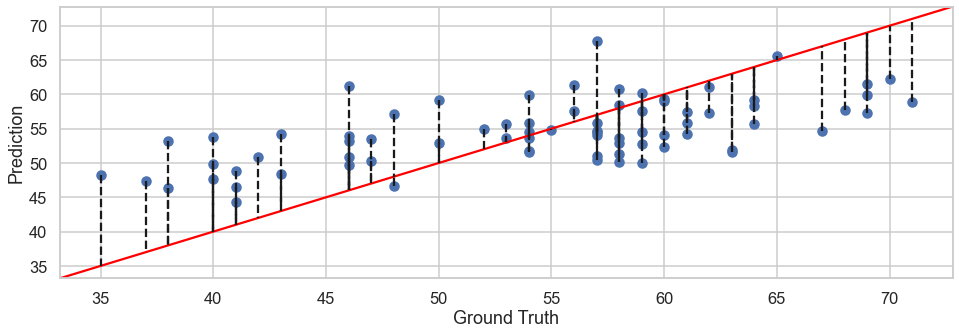

In [127]:
plt.figure(figsize = (16, 5))
_ = plt.scatter(y_test, y_pred)
_ = plt.axline(xy1 = (35,35), slope=1, c = "red")
_ = plt.plot([y_test, y_test], [y_pred, y_test], "--k")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")

The distance (represented as a black dotted line) between the y coordinates of the dots (i.e. the predicted values) and the red line correponds to the **error** that the model commits when predicting the age for each participant. The bigger is the distance, the worse is the prediction. This measure of distance can be used to evaluate the performance of a model. Since we want to obtain a general measure of performance of the model, we can assess how good the model is by checking the error that it commits for all the samples in the dataset.

The distance can be expressed as follows, where $y_{i}$ is the actual value and $\hat{y}_{i}$ is the predicted value.

$$ d = (y_{i}-\hat{y}_{i}) $$
Since we don't care about whether the distance is positive or negative, we take the squared distance
$$ d^2 = (y_{i}-\hat{y}_{i})^2 $$
Now, to obtain a general measure of performance, we can simply calculate the average squared distance across all datapoints as follows, where N is the total number of samples (or particpants).

$$ MSE = \frac{1}{N}\sum_{n=1}^{N}(y_{i}-\hat{y}_{i}) $$
This is defined as **mean squared error** and is the most common metric of performance of regression models. The bigger is the MSE, the worse is the model.

The problem with the MSE is that it is difficult to interpret out of context, as the range highly depends on what you are trying to predict.
For example, let's say your model predicts age, which is in the range of [0, 100]. An MSE of 25 would mean that on average your model is off by 5 years. That's not too bad. 
Now consider the case in which you are predicting yearly salary in pounds (range approx [20,000, 200,000]) and your model has an MSE of 25 as well. Considering that the range of values is much larger, an MSE of 25 in this context is much better.

That's why MSE values without context are not of much use. Normally you want to compare MSE values of different models against each other, or use a more normalized metric, like the $R^2$

The $R^2$ is an easier to interpret measure out of context. It is defined as how much of the variance is explained by the model, and it gives information about how better is the model compared to a mean model. It is calculated aa follows, where RESS is the residual error sum of squares and TSS is the total sum of squares:

$$ R^2 = 1 - \frac{RESS}{TSS}$$

To understand what they mean, look at the following figures and check their description below. In this case, we are plotting one of the X features, against the outcome variable (age). The line represents what the model would predict. 

For simplicity, the plot just draws a "dummy" diagonal line, because the model we trained was multivariate and therefore the slope of that model is not the same as if we had used only one variable. But the concept remains similar.

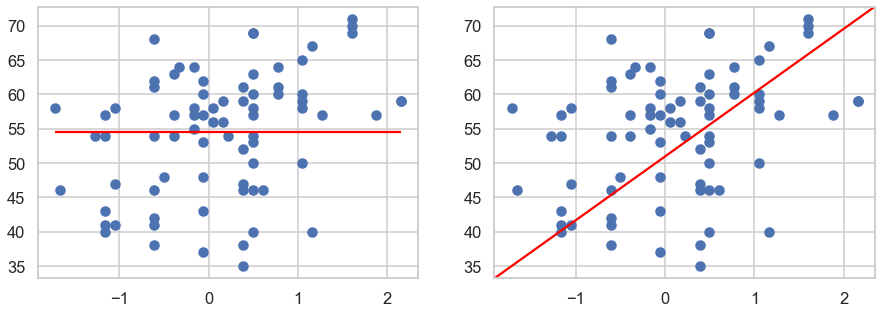

In [128]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.scatter(X_test[:, 2], y_test)
plt.hlines(y = np.mean(y_test), xmin = np.min(X_test[:, 2]),
           xmax =np.max(X_test[:, 2]), colors="red")
plt.subplot(122)
_ = plt.scatter(X_test[:, 2], y_test)
_ = plt.axline(
    xy1 = (np.min(X_test[:, 2]), np.min(y_test)),
    xy2 = (np.max(X_test[:, 2]), y_test.max()), 
    c = "red"
)


The TSS can be calculated as the distance from the actual values to values predicted by a mean model, namely a model that simply predicts the mean for each particpants. Instead, the RESS, corresponds to the squared distance between the actual and predicted values obtained by your model. The more similar is RESS to TSS, the closer is the R2 to 0, the worse is the model. If the R2 is negative, then it means that the RESS is bigger than TSS, which suggests that your model is worse than simply predicting the mean.

--------------
### Code here

1. **CODE HERE:** 

    * Define a function that calculates the MSE from scratch and use it on the trained regression model
    * Implement the K-Fold cross validation for regression, and use the mean squared error (MSE) as metric of performance. Plot the obtained MSEs using a boxplot.
    
    
2. **BONUS CODE HERE:** 

    * Define a function that calculates the R2 from scratch and use it on the trained regression model. Compare your results to the R2 calculated by sklearn, and check whether your measure is correct.
 

In [129]:
# CODE HERE

## The END
This is the end of the workshop. I hope you enjoyed it! If you have any questions, feel free to drop me an email v.giunchiglia20@imperial.ac.uk